In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## 1. Простейшие геометрические преобразования

### 1.1 Конформные преобразования

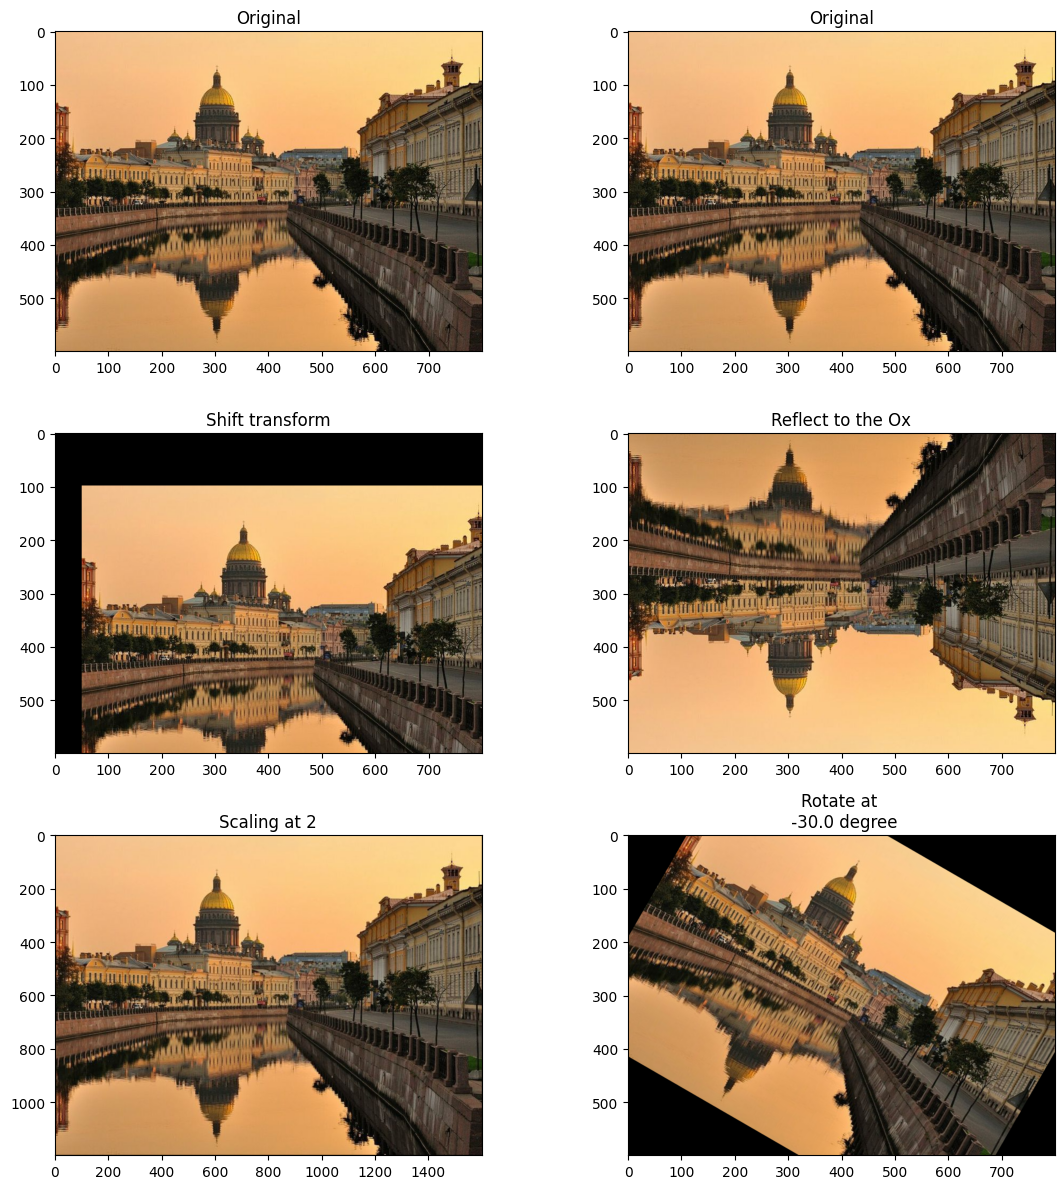

In [39]:
I = cv2.imread('spb_2.jpg')
rows, cols = I.shape[0:2]
#shift
T_shift = np.float32([[1 , 0 , 50], [0 , 1 , 100]])
I_shift = cv2.warpAffine(I, T_shift, (cols , rows))

#reflect
T_reflect = np.float32([[1 , 0 , 0], [0, -1, rows-1]])
I_reflect = cv2.warpAffine(I, T_reflect, (cols, rows))

#scale
scale_x = 2 
scale_y = 2
T_scale = np.float32([[scale_x , 0 , 0], [0, scale_y, 0]])
I_scale = cv2.warpAffine(I, T_scale, (int(cols*scale_x), int(rows*scale_y)))

#rotation
phi = 30.0
T_rotate = cv2.getRotationMatrix2D(((cols - 1) / 2.0, (rows - 1) / 2.0), -phi, 1)
I_rotate = cv2.warpAffine(I, T_rotate, (cols, rows))

#visualization
f, ax = plt.subplots(3,2, figsize=(12,12))
ax[0,0].imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
ax[0,0].set_title('Original')
ax[0,1].imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
ax[0,1].set_title('Original')
ax[1,0].imshow(cv2.cvtColor(I_shift, cv2.COLOR_BGR2RGB))
ax[1,0].set_title(f'Shift transform')
ax[1,1].imshow(cv2.cvtColor(I_reflect, cv2.COLOR_BGR2RGB))
ax[1,1].set_title('Reflect to the Ox')
ax[2,0].imshow(cv2.cvtColor(I_scale, cv2.COLOR_BGR2RGB))
ax[2,0].set_title(f'Scaling at {scale_x}')
ax[2,1].imshow(cv2.cvtColor(I_rotate, cv2.COLOR_BGR2RGB))
ax[2,1].set_title(f'Rotate at \n {-phi} degree')

plt.tight_layout()
plt.show()

### 1.2 Афинные преобразования: скос, неоднородное масштабирование

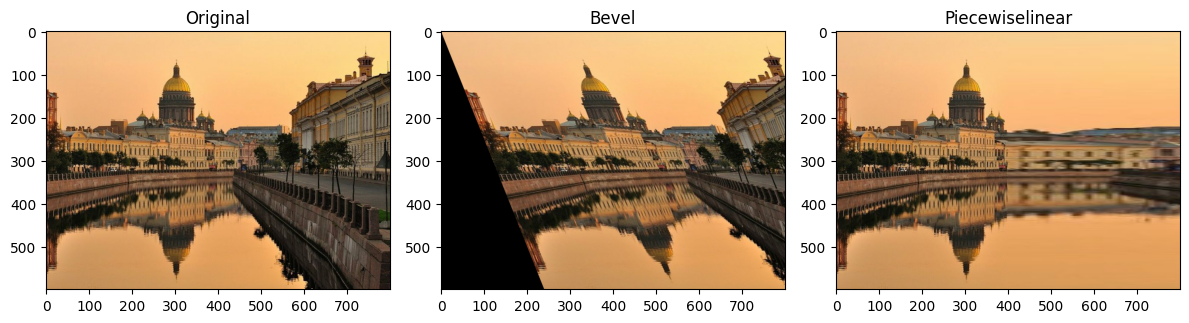

In [44]:
#bevel
s = 0.4
T_bevel = np.float32([[1, s, 0], [0, 1, 0]])
I_bevel =cv2.warpAffine(I, T_bevel, (cols, rows))

#piecewiselinear
stretch = 7
T_piecewiselinear = np.float32([[stretch, 0, 0], [0, 1, 0]])
I_piecewiselinear = I.copy()
I_piecewiselinear[:, int(cols/2):, :] = cv2.warpAffine(I_piecewiselinear[:, int(cols/2):, :], 
                                                              T_piecewiselinear, (cols-int(cols/2), rows))
#visualization
f, ax = plt.subplots(1,3, figsize=(12,12))
ax[0].imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original')
ax[1].imshow(cv2.cvtColor(I_bevel, cv2.COLOR_BGR2RGB))
ax[1].set_title('Bevel')
ax[2].imshow(cv2.cvtColor(I_piecewiselinear, cv2.COLOR_BGR2RGB))
ax[2].set_title('Piecewiselinear')

plt.tight_layout()
plt.show()


### 1.3 Проективное отображение

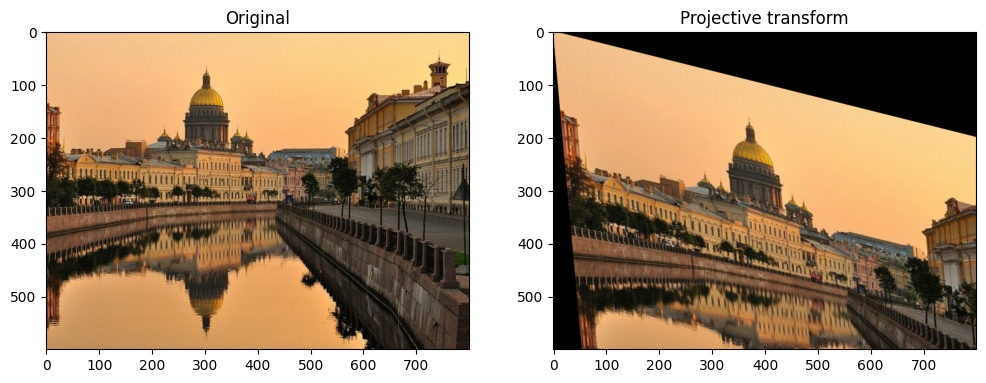

In [57]:
T_projective = np.float32([[1.2 , 0.1 , 0.00075], [0.3 , 1.1 , 0.0005], [0, 0 , 1]])
I_projective = cv2.warpPerspective (I ,T_projective ,(cols, rows))

f, ax = plt.subplots(1,2, figsize=(12,12))
ax[0].imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original')
ax[1].imshow(cv2.cvtColor(I_projective, cv2.COLOR_BGR2RGB))
ax[1].set_title(f'Projective transform')
plt.show()

## 2. Коррекция дисторсии

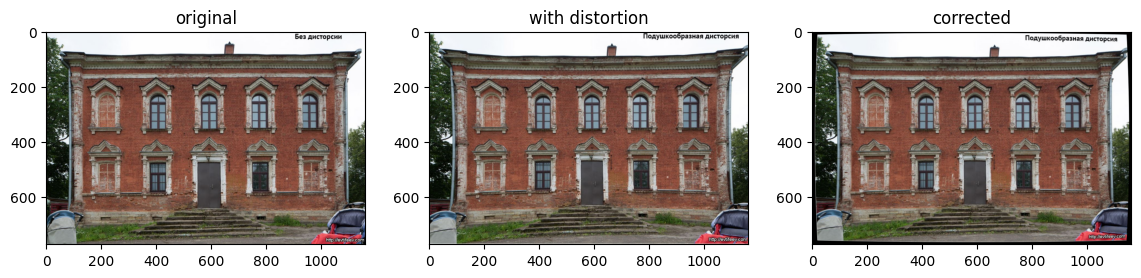

In [32]:
I_normal = cv2.imread('normal.jpg')
I_defect = cv2.imread('defect.jpg')
I_normal = I_normal[:-1, :-1, :] #чтобы были одинаковые размеры изображений
rows, cols = I_normal.shape[0:2]

#создание сетки
xi , yi = np.meshgrid(np.arange(cols), np.arange(rows))
xmid = cols / 2.0
ymid = rows / 2.0
xi = xi - xmid
yi = yi - ymid
r, theta = cv2.cartToPolar(xi / xmid , yi / ymid )

#определение точек, соответствующих одной точке реального изображения, коррекция дисторсии
delta_R = (r[38, 65] - r[51, 74]) 
F_3 = delta_R / (r[51, 74] ** 3)
r = r + F_3 * r ** 3 
u, v = cv2.polarToCart(r, theta)
u = u * xmid + xmid
v = v * ymid + ymid
I_barrel = cv2.remap(I_defect, u.astype(np.float32), v.astype(np.float32), cv2.INTER_LINEAR)


f, ax = plt.subplots(1,3, figsize=(14,14))
ax[0].imshow(cv2.cvtColor(I_normal, cv2.COLOR_BGR2RGB))
ax[0].set_title('original')
ax[2].imshow(cv2.cvtColor(I_barrel, cv2.COLOR_BGR2RGB))
ax[2].set_title('corrected')
ax[1].imshow(cv2.cvtColor(I_defect, cv2.COLOR_BGR2RGB))
ax[1].set_title('with distortion')
plt.show()


### 3. "Сшивка" изображений

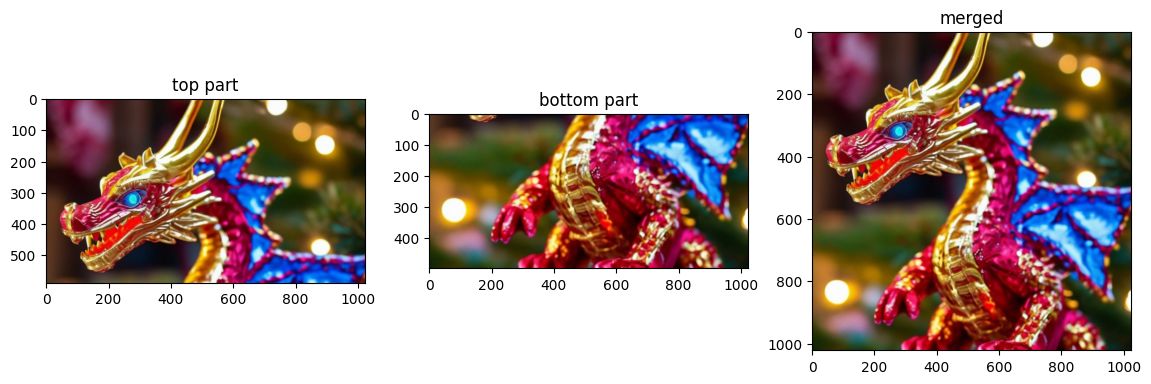

In [10]:
topPart = cv2.imread('top.png')
botPart = cv2.imread('bottom.png')


templ_size = 10
templ = topPart[-templ_size:,:,:]
res = cv2.matchTemplate( botPart, templ, cv2.TM_CCOEFF)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

result_img = np.zeros((topPart.shape[0] + botPart.shape[0] - max_loc[1] - 
                       templ_size, topPart.shape[1], topPart.shape[2]), dtype = np.uint8)
result_img[0:topPart.shape[0], :, :] = topPart
result_img[topPart.shape[0]:, :, :] = botPart[max_loc[1] + templ_size:, :, :]

f, ax = plt.subplots(1,3, figsize=(14,14))
ax[0].imshow(cv2.cvtColor(topPart, cv2.COLOR_BGR2RGB))
ax[0].set_title('top part')
ax[1].imshow(cv2.cvtColor(botPart, cv2.COLOR_BGR2RGB))
ax[1].set_title('bottom part')
ax[2].imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
ax[2].set_title('merged')
plt.show()